# Wasserstein Generative Adversarial Networks

A popular topic in GAN field is to stablize the training process. The original GAN suffers from several difficulties, e.g. mode collapse, where generator collapse into very narrow distribution that only covers a single mode in data distribution. Another problem in GAN is that there is no metric that tells us about the convergence. In the previous DCGAN tutorial, the loss of generator and discriminator doesn't indicate the training convergence at all! We need to manually monitor the generated images.

[Wasserstein GAN](http://arxiv.org/abs/1701.07875) can be used to remedy those two problems above.

Similar to DCGAN tutorial, we use [LWF Face Dataset](http://vis-www.cs.umass.edu/lfw/) as dataset.

## Basic Idea

GAN minimises the f-divergence between the real data distribution $P_r(x)$ and the generated data distribution $P_g(x)$ and the usual GAN objective turns out to be very similar to Jenson-Shannon (JS) divergence. JS divergenace turns out to be the major reason of vanishing gradient issue for GAN. Instead, [Earth-Mover distance](https://en.wikipedia.org/wiki/Earth_mover%27s_distance) is used in WGAN as an alternative to f-divergence.

## Implementation Modification
1. No log in the loss. The output of discriminator is no longer a probability, hence we do not apply sigmoid at the output of discriminator.
2. Clip the weight of discriminator.
3. Train discriminator more times tahn generator.
4. Use RMSProp instead of ADAM.
5. Lower learning rate. The paper uses 0.00005.


In [1]:
from __future__ import print_function
import os
import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
import numpy as np

## Set Training parameters

In [2]:
epochs = 100
batch_size = 64
latent_z_size = 100

use_gpu = True
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.00005
d_weight_min = -0.01
d_weight_max = 0.01
d_training_per_iter = 5

## Download and preprocess LWF Face Dataset

In [3]:

lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
data_path = 'lfw_dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    data_file = utils.download(lfw_url)
    with tarfile.open(data_file) as tar:
        tar.extractall(path=data_path)

We first resize images to size 64*64. Then normalize image pixel values to be between -1 and 1.

In [4]:
target_wd = 64
target_ht = 64
img_list = []

def transform(data, target_wd, target_ht):
    # resize to target_wd * target_ht
    data = mx.image.imresize(data, target_wd, target_ht)
    # transpose from (target_wd, target_ht, 3) 
    # to (3, target_wd, target_ht)
    data = mx.nd.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    data = data.astype(np.float32)/127.5 - 1
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = mx.nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, target_wd, target_ht)
        img_list.append(img_arr)
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size)

Visualize 4 images:

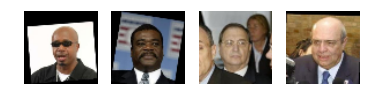

In [5]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(img_list[i + 10][0])
plt.show()

## Defining the networks

The core to DCGAN architecture is adopting and modifying CNN architecture:
* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).

* Use batchnorm in both the generator and the discriminator.

* Remove fully connected hidden layers for deeper architectures.

* Use ReLU activation in generator for all layers except for the output, which uses Tanh.

* Use LeakyReLU activation in the discriminator for all layers.

![alt text](img/dcgan.png "DCGAN Architecture")

In [6]:
# build the generator
nc = 3
ngf = 64
netG = nn.Sequential()
with netG.name_scope():
    # input is Z, going into a convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 8 x 8
    netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 16 x 16
    netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 32 x 32
    netG.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))
    # state size. (nc) x 64 x 64

# build the discriminator
ndf = 64
netD = nn.Sequential()
with netD.name_scope():
    # input is (nc) x 64 x 64
    netD.add(nn.Conv2D(ndf, 4, 2, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 32 x 32
    netD.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 16 x 16
    netD.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 8 x 8
    netD.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 4 x 4
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))

## Setup Optimizer
We use rmsprop as optimizer. Initialize parameters with normal distribution.

In [ ]:
# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'RMSProp', {'learning_rate': lr})
trainerD = gluon.Trainer(netD.collect_params(), 'RMSProp', {'learning_rate': lr})

## Training Loop
We recommend to use gpu to boost training. After a few epochs, we can see human-face-like images are generated

In [ ]:
from datetime import datetime
import time
import logging

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    for batch in train_data:
        ############################
        # (1) Update D network: maximize D(x) - D(G(z))
        ###########################
        data = batch.data[0].as_in_context(ctx)
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

        # Train disciminator more times
        for _ in range(d_training_per_iter):
            with autograd.record():
                outputR = netD(data).reshape((-1, 1))
                fake = netG(latent_z)
                outputF = netD(fake).reshape((-1, 1))
                errD = -(outputR - outputF)
                errD.backward()

            trainerD.step(batch.data[0].shape[0])
            # Weight clipping:
            for p in netD.collect_params():
                p.set_data(nd.clip(p.data, d_weight_min, d_weight_max))

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake = netG(latent_z)
            outputF = netD(fake).reshape((-1, 1))
            errG = -outputF
            errG.backward()

        trainerG.step(batch.data[0].shape[0])

        # Print log infomation every ten batches
        if iter % 10 == 0:
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f at iter %d epoch %d' 
                     %(nd.mean(errD).asscalar(), 
                       nd.mean(errG).asscalar(), iter, epoch))
        iter = iter + 1
        btic = time.time()

    logging.info('time: %f' % (time.time() - tic))

    # Visualize one generated image for each epoch
    fake_img = fake[0]
    visualize(fake_img)
    plt.show()

## results
Generate some face images with generator.


In [ ]:
num_image = 8
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    img = netG(latent_z)
    plt.subplot(2,4,i+1)
    visualize(img[0])
plt.show()

Walk in the latent space. We can see that small changes in the latent space result in smooth changes in generated images. This is a good sign that the model has learnt relevant and interesting representations.

In [ ]:
num_image = 12
latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
step = 0.05
for i in range(num_image):
    img = netG(latent_z)
    plt.subplot(3,4,i+1)
    visualize(img[0])
    latent_z += 0.05
plt.show()